<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S9/resnet_model_album_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Colab and importing generic Packages
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose)

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks\resnet')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/resnet')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#importing self-created packages:
import train_test_model_resnet18 as t                                           #import train - test module .This is class to train and evaluate the model
import load as ld                                                               #dataloader
import mod_summ as m                                                            #Getting model summary package
import Basic_Block as bb                                                        #Getting Classes for Resnet and Basic Block
import album as al                                                              #Getting albumentation module
import override_album as oa                                                     # overriding the albumentation class
import GradCm as gd                                                             #Grad Cam Module
import plot_cam   as pt                                                         #Plotting Image with Gradcam


In [0]:
# RESNET BLOCK
 def ResNet18():
  return bb.ResNet(bb.BasicBlock, [2,2,2,2])
def test():  
  net = ResNet18()
  y = net(torch.randn(1,3,32,32))
  return net

In [4]:
net=test().to('cuda') 
#net=test()#Net - Model to CUDA 
m.summ_print(net,(3,32,32))# Model summary.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
train_transforms,test_transforms=al.album_transform(albumentations)             #Albumentation class 

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=None)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = oa.PyTorchImageDataset(image=trainset, augmentations=train_transforms)
test_ds =  oa.PyTorchImageDataset(image=testset, augmentations=test_transforms)

In [0]:
batch_size=64
trainloader,testloader=ld.load_test_train(batch_size,train_ds,test_ds,torchvision,torch)

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
optimizer = optim.SGD(net.parameters(),lr=0.043,weight_decay=0.0019,momentum=0.90)
criterion=nn.CrossEntropyLoss()
scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.045, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
EPOCHS = 28
device='cuda'
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    t.train(net, device, trainloader, optimizer, epoch,train_losses,train_acc,tqdm,criterion)
    t.test(net, device, testloader,test_losses,test_acc,tqdm,criterion,torch)
    scheduler.step()


  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.3743679523468018 Batch_id=781 Accuracy=32.00: 100%|██████████| 782/782 [00:32<00:00, 24.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 4146/10000 (41.46%)

EPOCH: 1


Loss=1.680105209350586 Batch_id=781 Accuracy=42.56: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 4700/10000 (47.00%)

EPOCH: 2


Loss=1.2964569330215454 Batch_id=781 Accuracy=50.43: 100%|██████████| 782/782 [00:32<00:00, 24.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 6067/10000 (60.67%)

EPOCH: 3


Loss=1.2707552909851074 Batch_id=781 Accuracy=56.57: 100%|██████████| 782/782 [00:32<00:00, 24.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 5937/10000 (59.37%)

EPOCH: 4


Loss=1.28495192527771 Batch_id=781 Accuracy=59.95: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 5765/10000 (57.65%)

EPOCH: 5


Loss=0.7337675094604492 Batch_id=781 Accuracy=70.32: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 7960/10000 (79.60%)

EPOCH: 6


Loss=1.0495893955230713 Batch_id=781 Accuracy=73.50: 100%|██████████| 782/782 [00:32<00:00, 24.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 8110/10000 (81.10%)

EPOCH: 7


Loss=0.7908053398132324 Batch_id=781 Accuracy=75.12: 100%|██████████| 782/782 [00:31<00:00, 24.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 8309/10000 (83.09%)

EPOCH: 8


Loss=0.8893836736679077 Batch_id=781 Accuracy=76.79: 100%|██████████| 782/782 [00:31<00:00, 24.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8328/10000 (83.28%)

EPOCH: 9


Loss=0.6667233109474182 Batch_id=781 Accuracy=77.51: 100%|██████████| 782/782 [00:31<00:00, 24.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8293/10000 (82.93%)

EPOCH: 10


Loss=1.529575228691101 Batch_id=781 Accuracy=81.20: 100%|██████████| 782/782 [00:31<00:00, 25.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8632/10000 (86.32%)

EPOCH: 11


Loss=0.6514489650726318 Batch_id=781 Accuracy=82.44: 100%|██████████| 782/782 [00:31<00:00, 24.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8692/10000 (86.92%)

EPOCH: 12


Loss=0.44503113627433777 Batch_id=781 Accuracy=83.02: 100%|██████████| 782/782 [00:31<00:00, 24.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8701/10000 (87.01%)

EPOCH: 13


Loss=0.2130517065525055 Batch_id=781 Accuracy=83.70: 100%|██████████| 782/782 [00:31<00:00, 24.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8761/10000 (87.61%)

EPOCH: 14


Loss=0.508313000202179 Batch_id=781 Accuracy=84.14: 100%|██████████| 782/782 [00:31<00:00, 25.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8742/10000 (87.42%)

EPOCH: 15


Loss=0.5729169249534607 Batch_id=781 Accuracy=84.90: 100%|██████████| 782/782 [00:31<00:00, 24.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8793/10000 (87.93%)

EPOCH: 16


Loss=0.20522519946098328 Batch_id=781 Accuracy=84.99: 100%|██████████| 782/782 [00:31<00:00, 24.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8796/10000 (87.96%)

EPOCH: 17


Loss=0.4929307997226715 Batch_id=781 Accuracy=84.74: 100%|██████████| 782/782 [00:31<00:00, 24.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8794/10000 (87.94%)

EPOCH: 18


Loss=0.26579612493515015 Batch_id=781 Accuracy=85.07: 100%|██████████| 782/782 [00:31<00:00, 25.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8800/10000 (88.00%)

EPOCH: 19


Loss=0.5056599378585815 Batch_id=781 Accuracy=85.20: 100%|██████████| 782/782 [00:31<00:00, 24.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8821/10000 (88.21%)

EPOCH: 20


Loss=0.30893683433532715 Batch_id=781 Accuracy=85.23: 100%|██████████| 782/782 [00:31<00:00, 25.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8798/10000 (87.98%)

EPOCH: 21


Loss=0.3690774440765381 Batch_id=781 Accuracy=85.21: 100%|██████████| 782/782 [00:31<00:00, 25.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8811/10000 (88.11%)

EPOCH: 22


Loss=0.4145924150943756 Batch_id=781 Accuracy=85.33: 100%|██████████| 782/782 [00:31<00:00, 25.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8821/10000 (88.21%)

EPOCH: 23


Loss=0.5457932353019714 Batch_id=781 Accuracy=85.13: 100%|██████████| 782/782 [00:31<00:00, 25.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8805/10000 (88.05%)

EPOCH: 24


Loss=0.6550589799880981 Batch_id=781 Accuracy=85.28: 100%|██████████| 782/782 [00:31<00:00, 24.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8796/10000 (87.96%)

EPOCH: 25


Loss=0.6817231774330139 Batch_id=781 Accuracy=85.16: 100%|██████████| 782/782 [00:31<00:00, 24.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8821/10000 (88.21%)

EPOCH: 26


Loss=0.5397464036941528 Batch_id=781 Accuracy=85.25: 100%|██████████| 782/782 [00:31<00:00, 24.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8822/10000 (88.22%)

EPOCH: 27


Loss=0.7519020438194275 Batch_id=781 Accuracy=85.28: 100%|██████████| 782/782 [00:31<00:00, 24.97it/s]



Test set: Average loss: 0.0056, Accuracy: 8812/10000 (88.12%)



In [0]:
cam2=[]
data2=[]
dat1,label = next(iter(testloader))
for i in range(label.shape[0]):
 label1=label[i]
 data1=dat1[i]
 label1=label1.unsqueeze(0) 
 Gd1=gd.GradCm()
 cam1=Gd1.img(data1,label1,net)
 cam2.append(cam1)

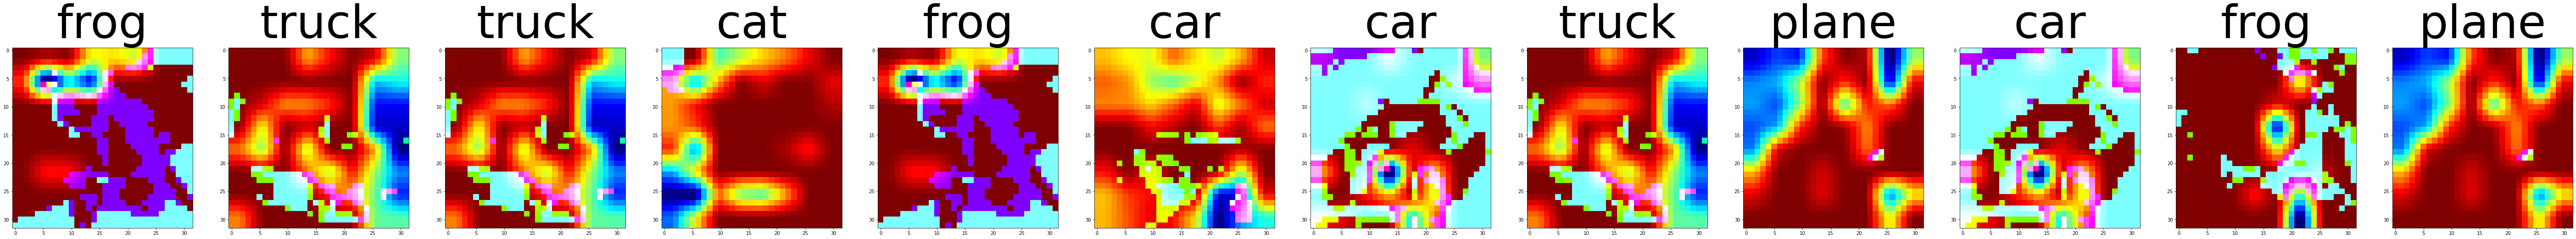

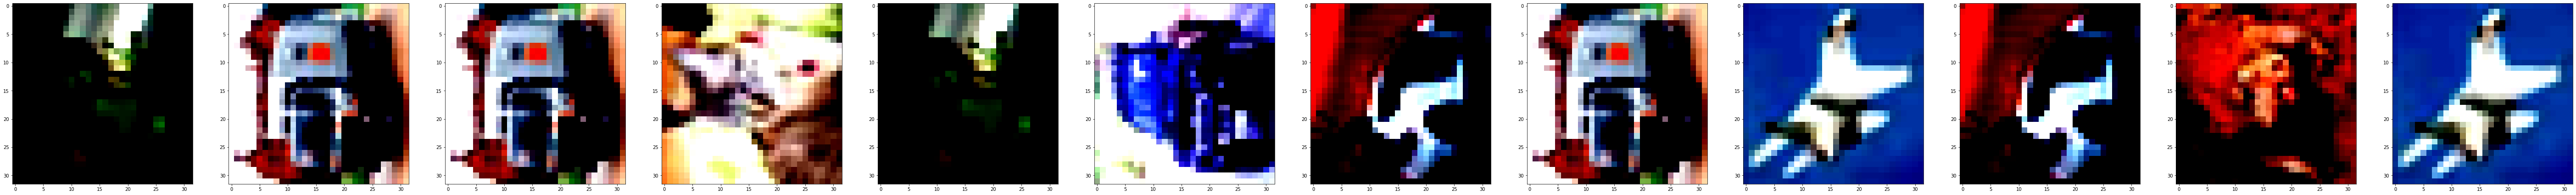

In [11]:
plott=pt.Plot()
plott.fig(dat1,cam2,label)